# Imports

In [380]:
import pandas as pd
import numpy as np
import random
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, Normalizer, Binarizer
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif,chi2

pd.options.display.max_rows = 15
import warnings
warnings.filterwarnings('ignore')

# Part One

## 1. Load  The Data

In [141]:
df=pd.read_json('logins.json', encoding="utf-8", orient='records')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [142]:
#check for na values
df[df['login_time'].isna()].shape

(0, 1)

## 2. EDA

### 2.1 On 15Min Frequency

#### 2.1.1 Preprocessing

In [143]:
from datetime import date 
import holidays
#create login count col
df['interval'] = df['login_time'].dt.floor('15T')
df=df.groupby('interval').size().reset_index(name='login_count')
#create day of week col
df['day_of_week']=df['interval'].dt.day_name()
df['weekday']= (df['interval'].dt.dayofweek < 5).astype(int)
#create is holidays col
us_holidays = holidays.US() 
def afunc(value):
    if value in us_holidays:
        return 1
    else:
        return 0
df['is_holiday']=df['interval'].apply(afunc)
#create date col
df['date']=df['interval'].dt.date

In [144]:
#check the new dataset
df.head()

,interval,login_count,day_of_week,weekday,is_holiday,date
0,1970-01-01 20:00:00,2,Thursday,1,1,1970-01-01
1,1970-01-01 20:15:00,6,Thursday,1,1,1970-01-01
2,1970-01-01 20:30:00,9,Thursday,1,1,1970-01-01
3,1970-01-01 20:45:00,7,Thursday,1,1,1970-01-01
4,1970-01-01 21:00:00,1,Thursday,1,1,1970-01-01


In [135]:
df.shape

(9381, 6)

In [136]:
df.login_count.describe()

count    9381.000000
mean        9.928792
std         8.263146
min         1.000000
25%         4.000000
50%         8.000000
75%        14.000000
max        73.000000
Name: login_count, dtype: float64

#### 2.1.2 Visalizing The Data

##### Login Counts During 15Min Interval

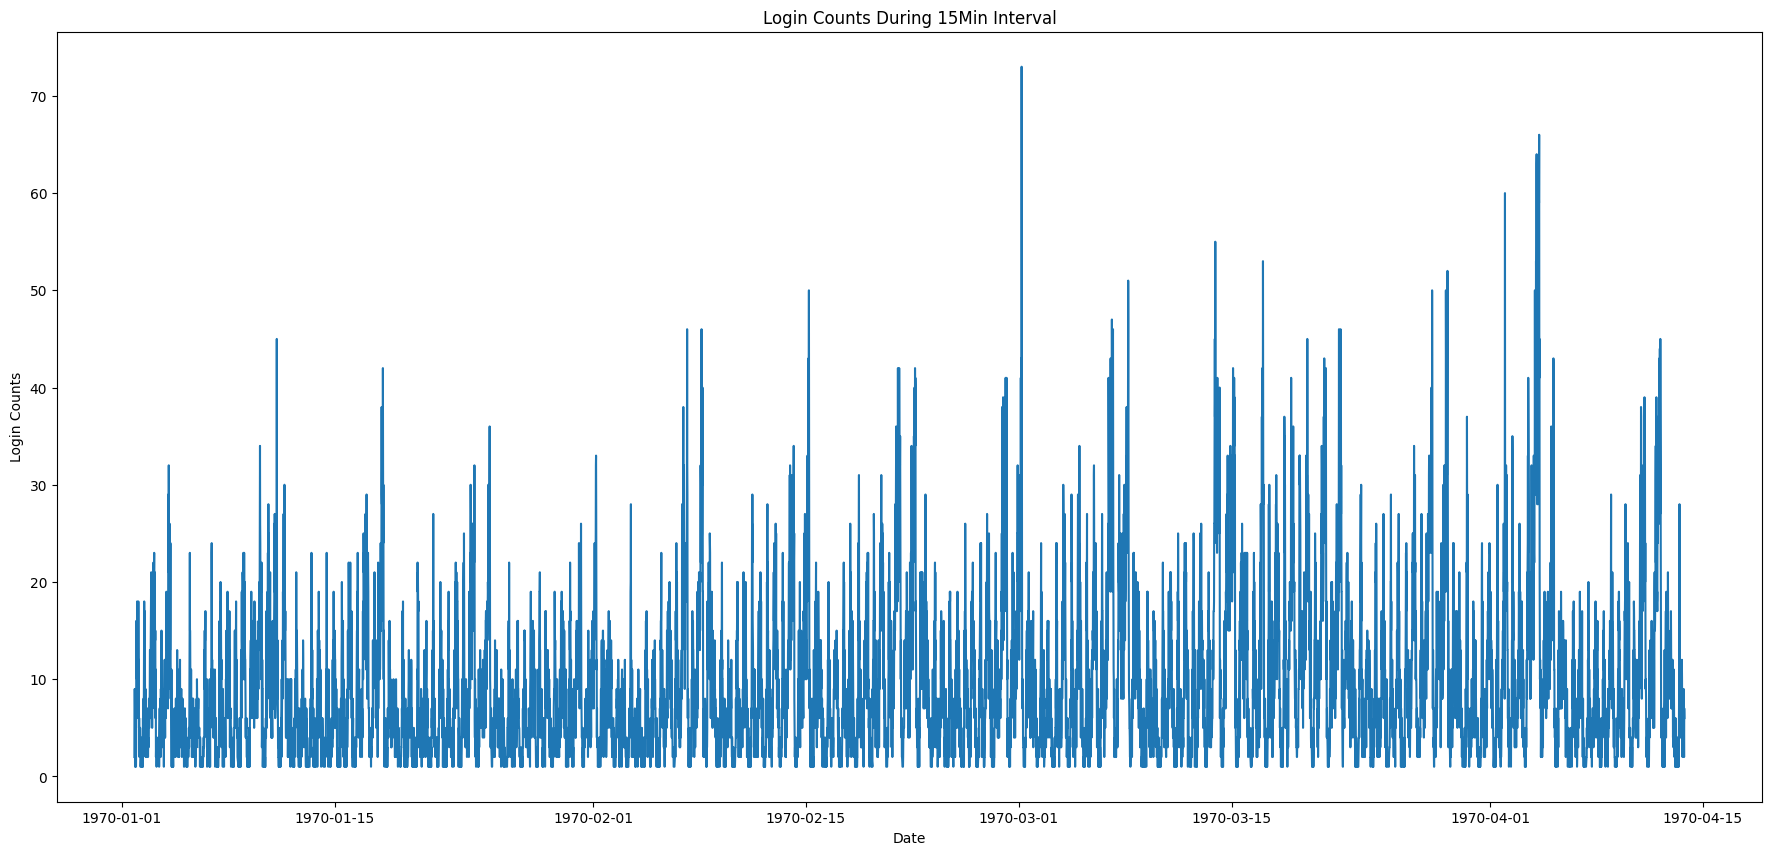

In [137]:
plt.figure(figsize=(22,10))
plt.plot(df.interval,df.login_count)
plt.title("Login Counts During 15Min Interval")
plt.xlabel("Date")
plt.ylabel("Login Counts")
plt.show()

Clearly we can see there are some pattens for the login counts. It have ups and downs dring a day and during a 7 days circle. But for the large scale we can hardly figure out what the pattens are, so I will continuing investigate the 7 days patten.

##### Login Counts During 15Min Interval In A 7days Time Cycle

In [138]:
# Filter data for the last 7 days
from datetime import datetime, timedelta
end_date = '1970-03-16'
start_date = '1970-03-09'
seven_days = df[(df['interval'] >= start_date) & (df['interval'] < end_date)]

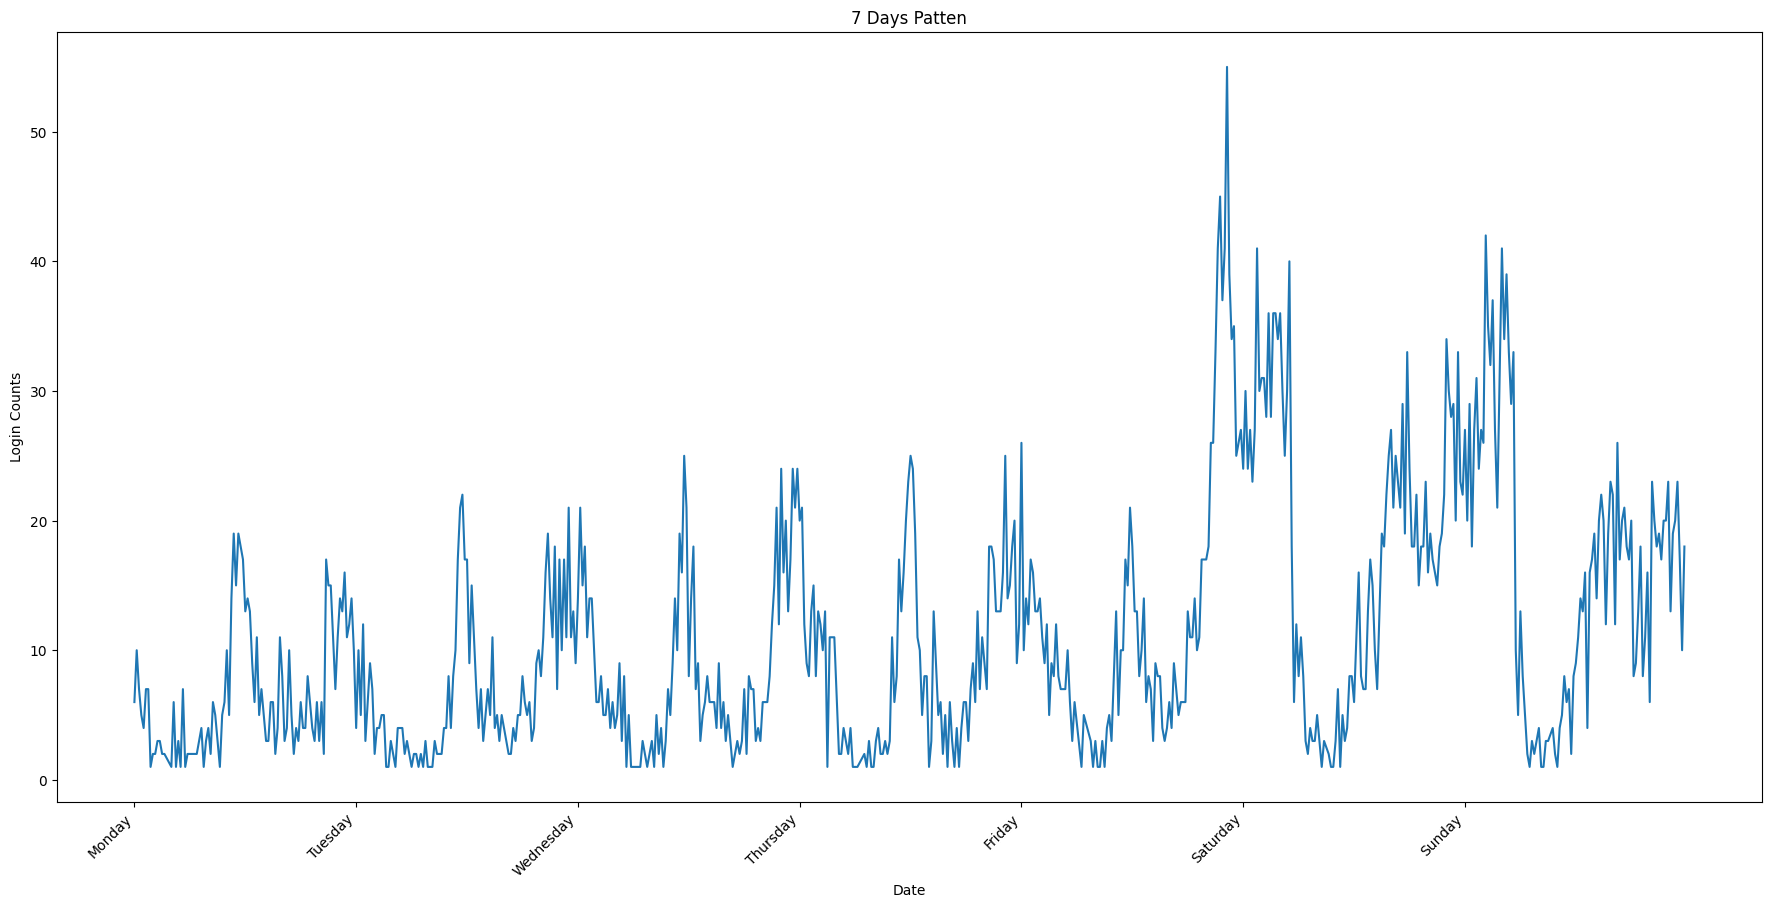

In [139]:
unique_days = seven_days.drop_duplicates('day_of_week')
plt.figure(figsize=(22,10))
plt.plot(seven_days.interval,seven_days.login_count)
plt.title("7 Days Patten")
plt.xticks(unique_days['interval'],unique_days['day_of_week'], rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Login Counts")
plt.show()

In general, the login counts are much higher during the weekends. And the daily patten for weekdays and weekends are different. In weekdays, there are two peaks, one is around the noon, and one is when approaching to midnight. But for Saturday and Sunday, the midnight peak last longer than the weekdays, sometime the login counts still high till 5-6am in the morning. And the noon peak kind of shift to 5-6pm during weekends and the counts keep going up to the midnight peak after a small drop after the afternoon peak.

##### Holiday Pattens

In [128]:
holiday = df[(df['is_holiday']==1)]
holiday.date.unique()

array([datetime.date(1970, 1, 1), datetime.date(1970, 2, 22)],
      dtype=object)

In [131]:
holiday_date = pd.to_datetime('1970-02-22').date()
holiday1= df[df['date']==holiday_date]
holiday1.head()

,interval,login_count,day_of_week,day_of_week_num,is_holiday,date
4667,1970-02-22 00:00:00,21,Sunday,6,1,1970-02-22
4668,1970-02-22 00:15:00,28,Sunday,6,1,1970-02-22
4669,1970-02-22 00:30:00,11,Sunday,6,1,1970-02-22
4670,1970-02-22 00:45:00,11,Sunday,6,1,1970-02-22
4671,1970-02-22 01:00:00,14,Sunday,6,1,1970-02-22


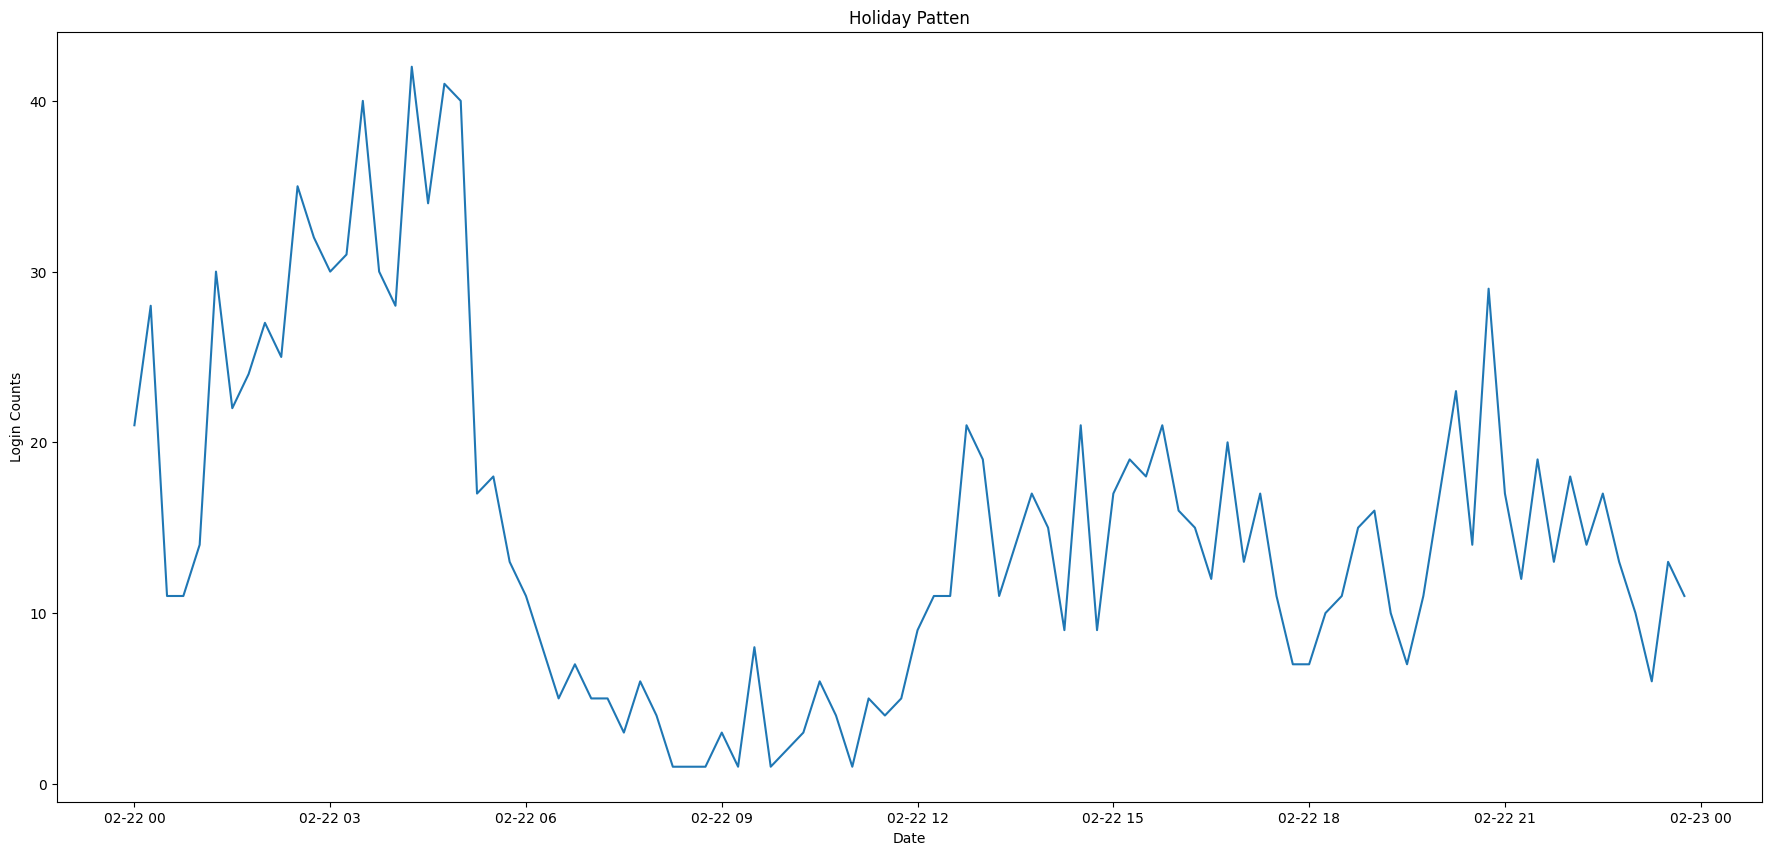

In [130]:
plt.figure(figsize=(22,10))
plt.plot(holiday1.interval,holiday1.login_count)
plt.title("Holiday Patten")
plt.xlabel("Date")
plt.ylabel("Login Counts")
plt.show()

This Holiday was on Sunday, we can't see any clear difference between this date and other Sunday.

### 2.2 On Daily Frequency

In [155]:
df1=df.groupby('date')['login_count'].sum().reset_index(name='login_count')
df1['date']=pd.to_datetime(df1['date'])

#### 2.2.1 Preprocessing

In [156]:
#create day of week col
df1['day_of_week']=df1['date'].dt.day_name()
df1['weekday']= (df1['date'].dt.dayofweek < 5).astype(int)
#create is holidays col
us_holidays = holidays.US() 
def afunc(value):
    if value in us_holidays:
        return 1
    else:
        return 0
df1['is_holiday']=df1['date'].apply(afunc)
df1.head()

,date,login_count,day_of_week,weekday,is_holiday
0,1970-01-01,112,Thursday,1,1
1,1970-01-02,681,Friday,1,0
2,1970-01-03,793,Saturday,0,0
3,1970-01-04,788,Sunday,0,0
4,1970-01-05,459,Monday,1,0


#### 2.2.2 Visalizing The Data

##### Weekdays Counts Vs Weekends Counts

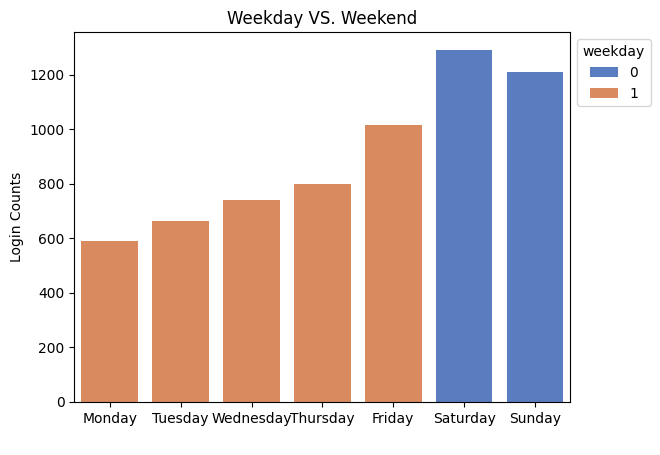

In [164]:
#Bar plot for total daily counts for weekdays and weekends.
order_sequence = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(
    df1, x='day_of_week', y='login_count',
    hue='weekday',
    estimator='mean',
    order= order_sequence,
    errorbar=None,
    palette="muted"
)
# set the label
ax.set_title("Weekday VS. Weekend")
ax.set(xlabel=' ', ylabel='Login Counts')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

The login counts keep increasing from Monday to Saturday, drop a little on Sunday. Overall as we said before, people use the system more on Weekends than on Weekdays.

##### Trends Based On Daily Cycle

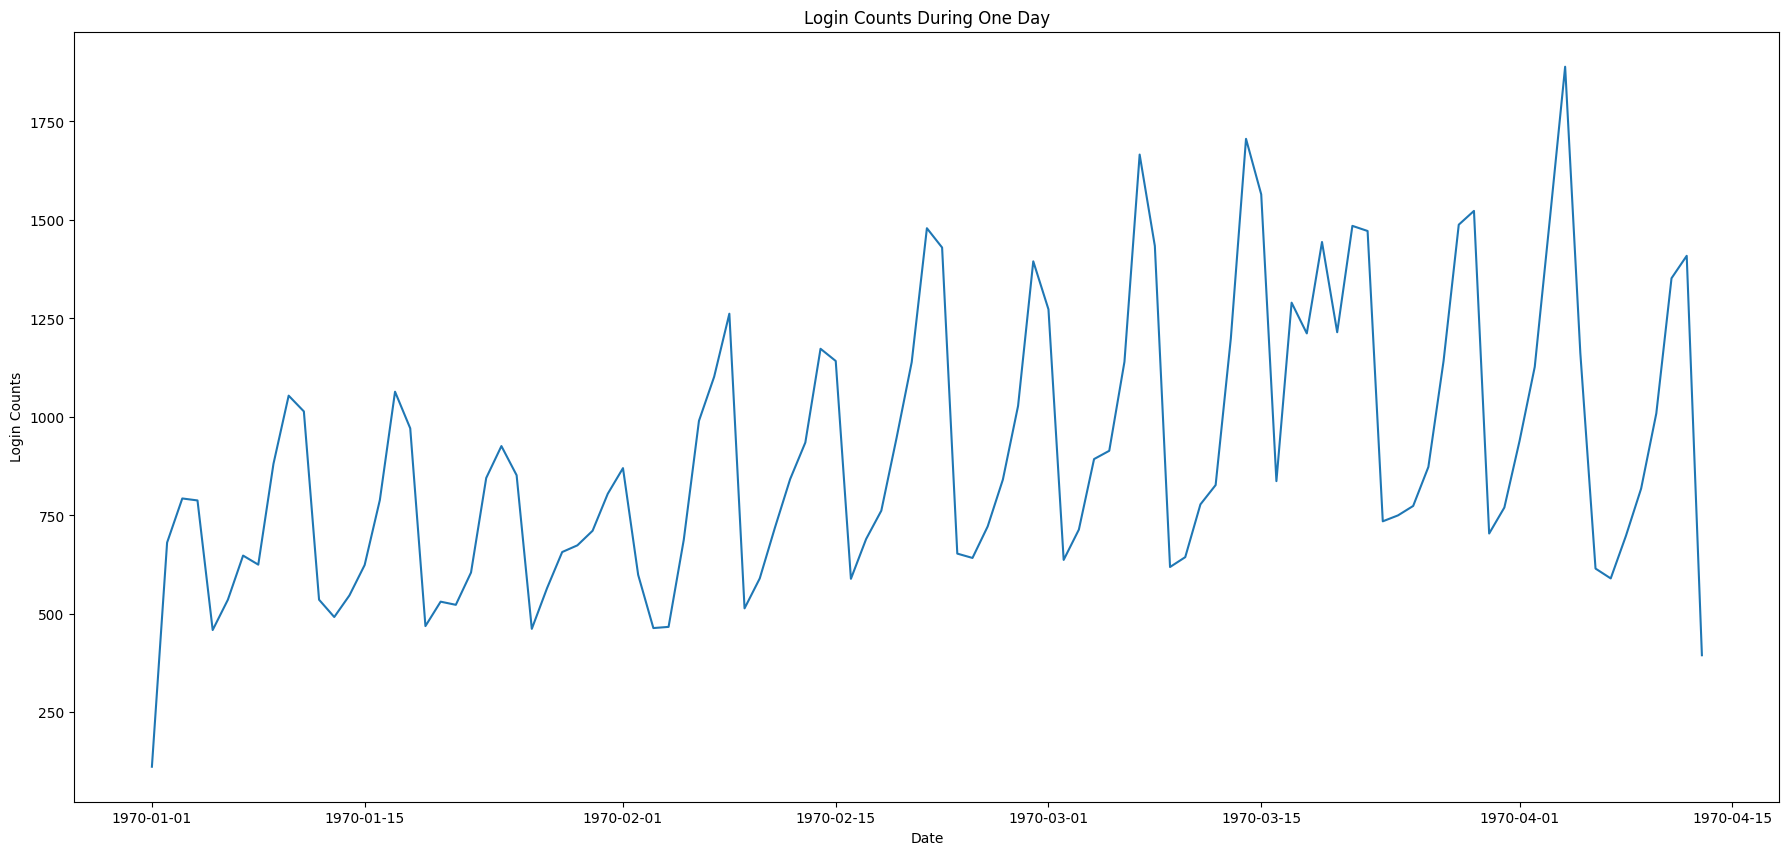

In [165]:
plt.figure(figsize=(22,10))
plt.plot(df1.date,df1.login_count)
plt.title("Login Counts During One Day")
plt.xlabel("Date")
plt.ylabel("Login Counts")
plt.show()

We can tell from the graph that there is a slightly increasing trend for the daily login counts.

# Part Two

## Experiment and metrics design

### Key Measure: 
The key measure of success for this experiment could be the increase in the number of driver partners crossing the toll bridge between Gotham and Metropolis during weekdays. Specifically, the goal is to observe a significant rise in the number of trips made by drivers between the two cities.\
An increase in cross-city trips would indicate that driver partners are taking advantage of the toll reimbursement and serving both cities, thereby achieving the goal of encouraging cross-city availability. This metric directly reflects the success of the experiment's objective—to make driver partners available in both cities and mitigate the exclusivity driven by the toll bridge. I want to apply the experiment on weekdays because on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. 

### Practical Experiment Design:
#### Experiment Details:
##### 1) Implementation:
Baseline Data Collection: Collect data on the number of cross-city trips before implementing the toll reimbursement.\
Implementation of Toll Reimbursement: Introduce the toll reimbursement policy and communicate it to all driver partners.\
Post-Implementation Data Collection: Track the number of cross-city trips after the toll reimbursement policy is in effect.\
Notes :Only collect the data on normal weekdays(exclude holidays and days that one of the city is holding special events)\
##### 2) Statistical Test(s):

Paired t-test: Conduct a paired test to compare the mean or median number of cross-city trips before and after the toll reimbursement. This will help determine if the change is statistically significant.\
Null Hypothesis (H0):\
Null hypothesis (H0) could be that the toll reimbursement policy has no effect on the number of cross-city trips made by driver partners. Mathematically, it can be expressed as:\
\
H0: μafter  -μbefore  =0\
\
Alternative Hypothesis (Ha):\
The alternative hypothesis (Ha) could be that the toll reimbursement policy has a significant effect on increasing the number of cross-city trips. Mathematically, it can be expressed as:\
\
Ha: μafter -μbefore >0

##### 3) Interpretation and Recommendations:

Interpretation of Results:\
If the p-value is significant (typically less than 0.05), it suggests that there is a statistically significant difference in the number of cross-city trips before and after the toll reimbursement.\
If the p-value is not significant, it indicates that the toll reimbursement might not have a substantial impact on encouraging cross-city trips.\
However, statistical significance doesn't always equate to practical significance or meaningful impact in the real world. In the context of the experiment on toll reimbursement for cross-city trips, even if the test shows a statistically significant increase, the magnitude of that increase might be too small to be practically significant or economically viable. So, we need to include other metrics such as Effect Size. In this case, we should consider whether the observed increase in cross-city trips is practically significant for the city operations and the overall goals of the policy. If the increase is minimal and doesn't have a meaningful impact on service availability or user experience, it might not be worth the resources invested in the toll reimbursement policy.\
#### Recommendations:
If the test results are significant, and the observation is practically significant, recommend continuing the toll reimbursement policy to encourage further cross-city service.\
If the test results are significant, but the observation is not practically significant, or the test results are not significant, assess other potential barriers or considerations that may be influencing driver behavior.


# Part Three

## 1. Load The Data

In [341]:
ultimate=pd.read_json('ultimate_data_challenge.json', encoding="utf-8", orient='records')
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## 2. Explore The Data

In [342]:
#check if there are duplicated rows
duplicate=sum(ultimate.duplicated())
duplicate

8

In [343]:
ultimate=ultimate.drop_duplicates()
#check again
duplicate=sum(ultimate.duplicated())
duplicate

0

In [344]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49992 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49992 non-null  object 
 1   trips_in_first_30_days  49992 non-null  int64  
 2   signup_date             49992 non-null  object 
 3   avg_rating_of_driver    41873 non-null  float64
 4   avg_surge               49992 non-null  float64
 5   last_trip_date          49992 non-null  object 
 6   phone                   49596 non-null  object 
 7   surge_pct               49992 non-null  float64
 8   ultimate_black_user     49992 non-null  bool   
 9   weekday_pct             49992 non-null  float64
 10  avg_dist                49992 non-null  float64
 11  avg_rating_by_driver    49791 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [345]:
ultimate.phone.value_counts()

phone
iPhone     34578
Android    15018
Name: count, dtype: int64

In [346]:
ultimate.city.value_counts()

city
Winterfell        23331
Astapor           16531
King's Landing    10130
Name: count, dtype: int64

## 3. Data Wrangling 

In [347]:
ultimate['signup_date']=pd.to_datetime(ultimate['signup_date'])
ultimate['last_trip_date']=pd.to_datetime(ultimate['last_trip_date'])

In [348]:
#drop the rows that don't have the phone info
ultimate=ultimate.dropna(subset=['phone'])
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49596 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49596 non-null  object        
 1   trips_in_first_30_days  49596 non-null  int64         
 2   signup_date             49596 non-null  datetime64[ns]
 3   avg_rating_of_driver    41573 non-null  float64       
 4   avg_surge               49596 non-null  float64       
 5   last_trip_date          49596 non-null  datetime64[ns]
 6   phone                   49596 non-null  object        
 7   surge_pct               49596 non-null  float64       
 8   ultimate_black_user     49596 non-null  bool          
 9   weekday_pct             49596 non-null  float64       
 10  avg_dist                49596 non-null  float64       
 11  avg_rating_by_driver    49398 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1)

### Feature Engineering 

In [349]:
ultimate['sign_6month_date']=ultimate['signup_date']+pd.Timedelta('180D')

In [350]:
#create the target 
ultimate['active']=(ultimate['sign_6month_date']-ultimate['last_trip_date'] <= pd.Timedelta('30D')).astype(int)
ultimate=ultimate.drop('sign_6month_date', axis=1)
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [351]:
#change the bool feature into binary feature
ultimate['ultimate_black_user']=ultimate['ultimate_black_user'].astype(int)
# one hot encoding the categorical features
ultimate = pd.get_dummies(ultimate,columns=['city','phone'], dtype=int)
#drop useless features
ultimate=ultimate.drop(['signup_date','last_trip_date'], axis=1)

### Outliers

In [352]:
stats=ultimate.describe().T
stats

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,49596.0,2.277462,3.793572,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41573.0,4.601419,0.617399,1.0,4.30,4.90,5.00,5.00
avg_surge,49596.0,1.075003,0.222682,1.0,1.00,1.00,1.05,8.00
surge_pct,49596.0,8.876746,19.990312,0.0,0.00,0.00,8.70,100.00
ultimate_black_user,49596.0,0.375212,0.484182,0.0,0.00,0.00,1.00,1.00
weekday_pct,49596.0,60.887604,37.082944,0.0,33.30,66.70,100.00,100.00
avg_dist,49596.0,5.785853,5.669961,0.0,2.42,3.88,6.93,160.96
avg_rating_by_driver,49398.0,4.777825,0.447141,1.0,4.70,5.00,5.00,5.00
active,49596.0,0.254637,0.435662,0.0,0.00,0.00,1.00,1.00
city_Astapor,49596.0,0.330873,0.470532,0.0,0.00,0.00,1.00,1.00


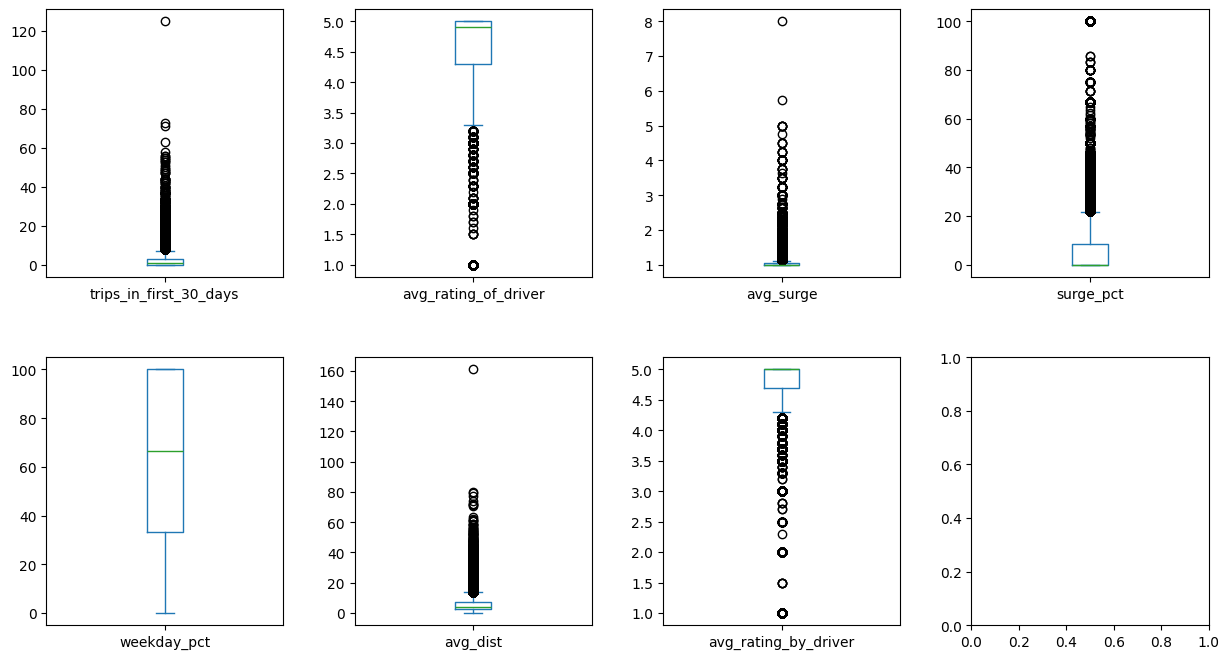

In [353]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

#trips_in_first_30_days
ultimate.trips_in_first_30_days.plot(kind='box', ax=ax[0,0])

#avg_rating_of_driver
ultimate.avg_rating_of_driver.plot(kind='box', ax=ax[0,1])

#avg_surge
ultimate.avg_surge.plot(kind='box', ax=ax[0,2])

#surge_pct
ultimate.surge_pct.plot(kind='box', ax=ax[0,3])

#weekday_pct
ultimate.weekday_pct.plot(kind='box', ax=ax[1,0])

#avg_dist
ultimate.avg_dist.plot(kind='box', ax=ax[1,1])

#avg_rating_by_driver
ultimate.avg_rating_by_driver.plot(kind='box', ax=ax[1,2])

#Give the subplots a little "breathing room" with a wspace of 0.8
plt.subplots_adjust(wspace=0.3,hspace=0.3)

Most of these features have outliers.

In [354]:
#calculate the upper and lower 3 sigma values for each cols
stats['lower_limit']=stats['mean']-(3*stats['std'])
stats['upper_limit']=stats['mean']+(3*stats['std'])
# find the cols that have a min value that less than the lower_limit
outlier_lower=stats[stats.lower_limit>stats['min']]
outlier_lower

,count,mean,std,min,25%,50%,75%,max,lower_limit,upper_limit
avg_rating_of_driver,41573.0,4.601419,0.617399,1.0,4.3,4.9,5.0,5.0,2.749222,6.453616
avg_rating_by_driver,49398.0,4.777825,0.447141,1.0,4.7,5.0,5.0,5.0,3.436402,6.119248


In [355]:
count1=len(ultimate[ultimate['avg_rating_by_driver']<3.436402])
count2=len(ultimate[ultimate['avg_rating_of_driver']<2.749222])
print(count1,count2)

999 656


In [356]:
# find the cols that have a max value that more than the upper_limit
outlier_upper=stats[stats.upper_limit<stats['max']]
outlier_upper

,count,mean,std,min,25%,50%,75%,max,lower_limit,upper_limit
trips_in_first_30_days,49596.0,2.277462,3.793572,0.0,0.00,1.00,3.00,125.00,-9.103253,13.658177
avg_surge,49596.0,1.075003,0.222682,1.0,1.00,1.00,1.05,8.00,0.406957,1.743049
surge_pct,49596.0,8.876746,19.990312,0.0,0.00,0.00,8.70,100.00,-51.094190,68.847682
avg_dist,49596.0,5.785853,5.669961,0.0,2.42,3.88,6.93,160.96,-11.224029,22.795735


In [357]:
counts1=len(ultimate[ultimate['trips_in_first_30_days']>13.658177])
counts2=len(ultimate[ultimate['avg_surge']>1.743049])
counts3=len(ultimate[ultimate['surge_pct']>68.847682])
counts4=len(ultimate[ultimate['avg_dist']>22.795735])
print(counts1,counts2,counts3,counts4)

1070 1137 1465 956


There are too much outliers, we will lose a lot of data if we drop all of them, so in this projiect I will only drop the max/min value for these features that have outliers.

In [358]:
#drop minmum value of the feature that have lower outliers
ultimate=ultimate[ultimate.avg_rating_by_driver!=1]
ultimate=ultimate[ultimate.avg_rating_of_driver!=1]
#drop maxmum value of the feature that have lower outliers
ultimate=ultimate[ultimate.trips_in_first_30_days!=125]
ultimate=ultimate[ultimate.avg_surge!=8]
ultimate=ultimate[ultimate.surge_pct!=100]
ultimate=ultimate[ultimate.avg_dist!=160.96]
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47788 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  47788 non-null  int64  
 1   avg_rating_of_driver    40429 non-null  float64
 2   avg_surge               47788 non-null  float64
 3   surge_pct               47788 non-null  float64
 4   ultimate_black_user     47788 non-null  int64  
 5   weekday_pct             47788 non-null  float64
 6   avg_dist                47788 non-null  float64
 7   avg_rating_by_driver    47623 non-null  float64
 8   active                  47788 non-null  int64  
 9   city_Astapor            47788 non-null  int64  
 10  city_King's Landing     47788 non-null  int64  
 11  city_Winterfell         47788 non-null  int64  
 12  phone_Android           47788 non-null  int64  
 13  phone_iPhone            47788 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 5.5 M

## 3. EDA

In [359]:
ultimate['active'].value_counts()

active
0    35322
1    12466
Name: count, dtype: int64

In [360]:
ultimate.columns

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active', 'city_Astapor', 'city_King's Landing',
       'city_Winterfell', 'phone_Android', 'phone_iPhone'],
      dtype='object')

There was only 26% of the rider remain active at the end of their 6th month. Let's investagte the retainrate in different categories.

In [361]:
binary_features=['ultimate_black_user', 'city_Astapor',"city_King's Landing",'city_Winterfell', 'phone_Android', 'phone_iPhone' ]

In [362]:
#Define the function:
def retainrate(col_name,data=ultimate):
    active_by_col= data[data.active==1][col_name].value_counts()
    retainrate_by_col = active_by_col/data[col_name].value_counts()
    return retainrate_by_col

In [363]:
for col in binary_features:
    print(retainrate(col,ultimate))

ultimate_black_user
0    0.205811
1    0.349072
Name: count, dtype: float64
city_Astapor
0    0.301753
1    0.177116
Name: count, dtype: float64
city_King's Landing
0    0.219231
1    0.421835
Name: count, dtype: float64
city_Winterfell
0    0.271355
1    0.248856
Name: count, dtype: float64
phone_Android
0    0.313074
1    0.139447
Name: count, dtype: float64
phone_iPhone
1    0.313074
0    0.139447
Name: count, dtype: float64


Form the caculation above we can esaily infer that city do have impact on the retainrate, the city King's Landing have the highest retainrate, while the city Astapor have the lowest. In general Iphone user are more likely to being still active user after 6 months. If the user took an Ultimate Black in their first 30 days, they are more likely to stay after six months.

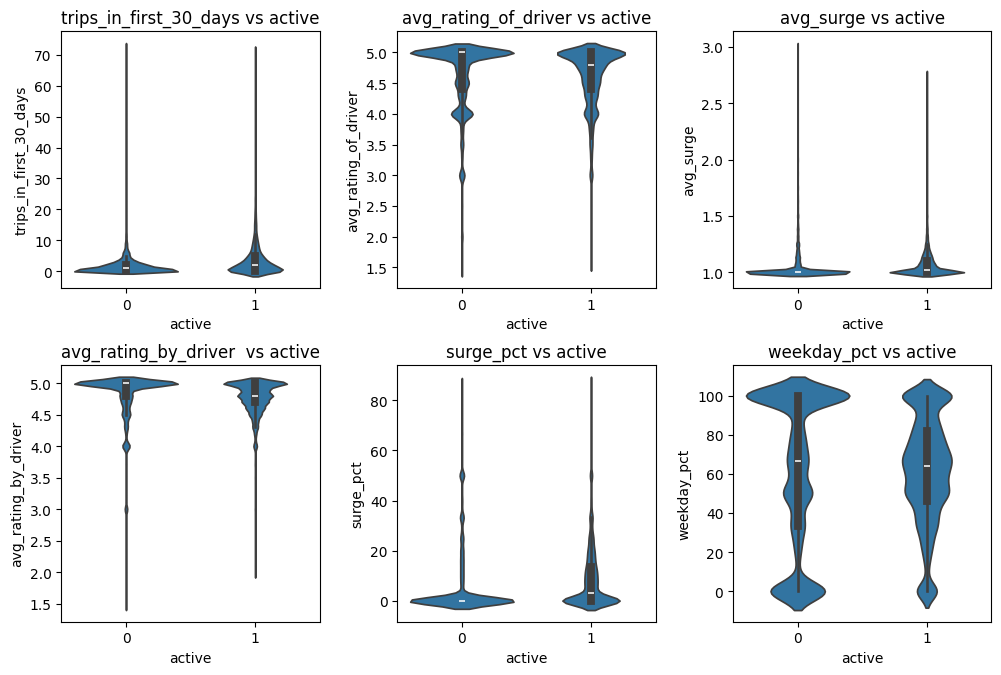

In [367]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.subplot(331)
sns.violinplot(data=ultimate, x='active', y='trips_in_first_30_days')
plt.title ('trips_in_first_30_days vs active')

plt.subplot(332)
sns.violinplot(data=ultimate, x='active', y='avg_rating_of_driver')
plt.title ('avg_rating_of_driver vs active')

plt.subplot(333)
sns.violinplot(data=ultimate, x='active', y='avg_surge')
plt.title ('avg_surge vs active')

plt.subplot(334)
sns.violinplot(data=ultimate, x='active', y='avg_rating_by_driver')
plt.title ('avg_rating_by_driver  vs active')

plt.subplot(335)
sns.violinplot(data=ultimate, x='active', y='surge_pct')
plt.title ('surge_pct vs active')

plt.subplot(336)
sns.violinplot(data=ultimate, x='active', y='weekday_pct')
plt.title ('weekday_pct vs active')

plt.subplots_adjust(wspace=0.3,hspace=0.3)


Analyzing the graphs provided, it is evident that users who continue to use the platform took more trips within their initial 30 days after registration. Despite this higher trip frequency, their overall driver ratings are lower compared to users who are no longer active. Simultaneously, these retained users also receive lower ratings from their drivers. This discrepancy may be attributed to the fact that retained users, due to their increased trip activity, both submit and receive more ratings.\
Furthermore, the percentage of trips taken with surge multipliers is higher among retained users. Notably, a significant portion of retained users opts for weekday trips, while a considerable proportion of inactive users either restrict their trips exclusively to weekdays or weekends.


## 4. Modeling

### 4.1 Training Testing Split

In [368]:
X=ultimate.drop('active', axis=1)
y=ultimate[['active']]
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=12)

### 4.2 Fill Missing Value

In [369]:
features=['avg_rating_of_driver','avg_rating_by_driver']
X_train[features]=X_train[features].fillna(X_train[features].median())
X_test[features]=X_test[features].fillna(X_train[features].median())

### 4.3 Models

### Random Forest

In [413]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [414]:
rf=RandomForestClassifier(random_state=12)
kf = KFold(n_splits=5, shuffle=True, random_state=12)
# Perform cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')
print("Average F1 Score:", scores.mean())

Average F1 Score: 0.5106445777708737


In [426]:
param_dist = {
        'n_estimators': range(5,150,1),
        'criterion':['gini', 'entropy'],
        'max_features': ['sqrt', 'log2',None],
        'max_depth': (1,90,1),
        'min_samples_split': range(2,10,1),
        'min_samples_leaf': range(1,7,1)
    }
start=time.time()
rf_random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1',random_state=12)
rf_random_search.fit(X_train, y_train)
end=time.time()
cost=end-start
print('Time consuming(Seconds):',cost)

Time consuming(Seconds): 435.15287590026855


In [430]:
best_model = rf_random_search.best_estimator_
best_params = rf_random_search.best_params_
best_score = rf_random_search.best_score_
y_pred = best_model.predict(X_test)
y_trainpred = best_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)


Best Parameters: {'n_estimators': 117, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 90, 'criterion': 'entropy'}
Best Model's Mean Cross-Validation Score: 0.5288489989020564
Train Accuracy: 0.9069840439445461
Test Accuracy: 0.7878217200251099
Train MAE: 0.09301595605545383
Test MAE: 0.21217827997489014
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      7104
           1       0.62      0.46      0.53      2454

    accuracy                           0.79      9558
   macro avg       0.72      0.68      0.70      9558
weighted avg       0.77      0.79      0.78      9558



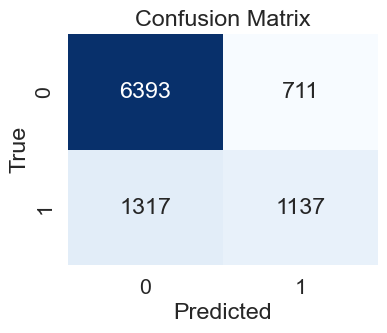

In [431]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

0.8108439945905563


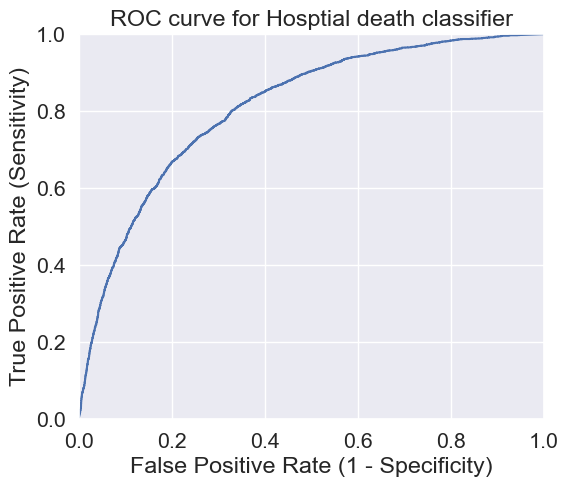

In [433]:
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Hosptial death classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(roc_auc_score(y_test, y_pred_prob))

### XGboost

In [434]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
steps=[('scaler',StandardScaler()), 
       ('model', xgb.XGBClassifier(objective='binary:logistic'))] 
pipeline=Pipeline(steps=steps)

kf = KFold(n_splits=5, shuffle=True, random_state=12)
# Perform cross-validation
scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')
print("Average F1 Score:", scores.mean())

Average F1 Score: 0.5368185871721128


In [435]:
param_dist = {
        'model__eta': sp_rand(0,1),
        'model__gamma':sp_rand(0,10),
        'model__min_child_weight': (1,10,1),
        'model__max_depth': (1,90,1),
        'model__colsample_bytree': sp_rand(0,1),
        'model__subsample': sp_rand(0,1),
        'model__lambda': sp_rand(0,10)
    }
start=time.time()
xgb_random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1',random_state=12)
xgb_random_search.fit(X_train, y_train)
end=time.time()
cost=end-start
print('Time consuming(Seconds):',cost)

Time consuming(Seconds): 259.9437108039856


In [436]:
best_model = xgb_random_search.best_estimator_
best_params = xgb_random_search.best_params_
best_score = xgb_random_search.best_score_
y_pred = best_model.predict(X_test)
y_trainpred = best_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
accuracy_train= accuracy_score(y_train, y_trainpred)
mae_train=mean_absolute_error(y_train, y_trainpred)
mae_test=mean_absolute_error(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Model's Mean Cross-Validation Score:", best_score)
print("Train Accuracy:",accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train MAE:",mae_train)
print("Test MAE:", mae_test)
print("Classification Report:\n", report)

Best Parameters: {'model__colsample_bytree': 0.5734288492560975, 'model__eta': 0.6429332736267166, 'model__gamma': 9.128459654074533, 'model__lambda': 6.002177636619166, 'model__max_depth': 90, 'model__min_child_weight': 10, 'model__subsample': 0.7424103131767936}
Best Model's Mean Cross-Validation Score: 0.539133393035075
Train Accuracy: 0.8088935391054146
Test Accuracy: 0.796400920694706
Train MAE: 0.1911064608945854
Test MAE: 0.203599079305294
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      7104
           1       0.64      0.46      0.54      2454

    accuracy                           0.80      9558
   macro avg       0.74      0.69      0.70      9558
weighted avg       0.78      0.80      0.78      9558



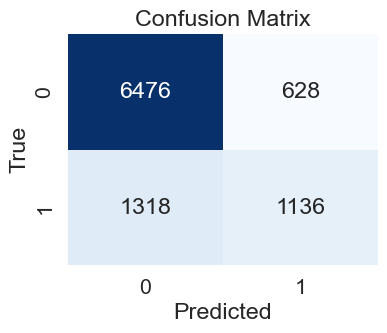

In [437]:
confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.4)  # Adjust the font scale for readability
# Use seaborn's heatmap to plot the confusion matrix
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('True')
# Add a title
plt.title('Confusion Matrix')
# Show the plot
plt.show()

AUC : 0.82579766120032


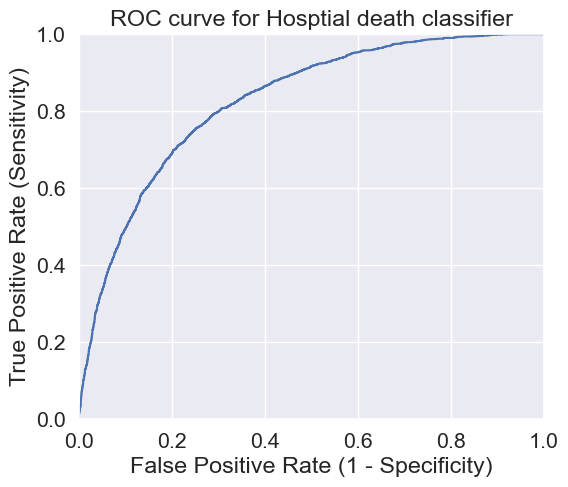

In [439]:
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Hosptial death classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print('AUC :',roc_auc_score(y_test, y_pred_prob))

Both model works ok, XGBoost perform slightly better. So I will choose XGBoost as my best model for this project. It has an overall 80% accuracy which is a decent score. Model works better on predicting the negative value(0) of the target.

## 5.  Evaluate The Best Model

### Feature Importance

In [449]:
#XGB MODEL FEATURE IMPORTANCE
best_model = xgb_random_search.best_estimator_
importances=best_model.named_steps['model'].feature_importances_
pd.Series(importances, index=X.columns).sort_values()

avg_dist                  0.009447
avg_rating_of_driver      0.012331
city_Winterfell           0.014183
surge_pct                 0.014722
trips_in_first_30_days    0.020718
weekday_pct               0.035887
city_Astapor              0.045427
phone_Android             0.048425
avg_rating_by_driver      0.080206
city_King's Landing       0.098459
avg_surge                 0.100376
ultimate_black_user       0.136379
phone_iPhone              0.383441
dtype: float32

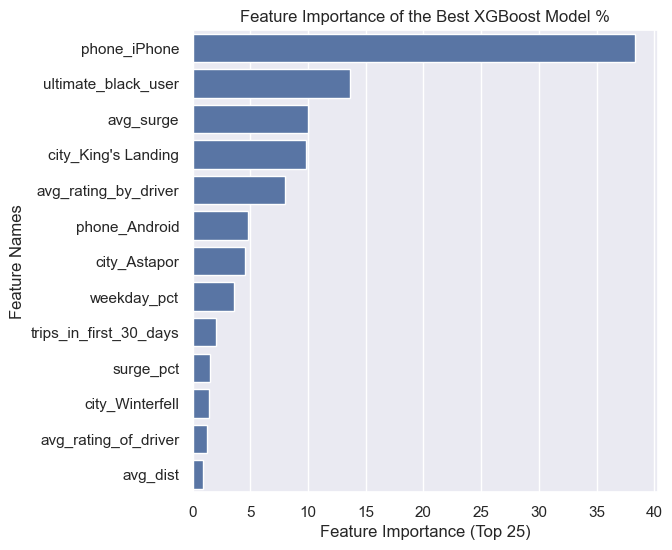

In [445]:
feature_importance=pd.DataFrame({'Feature_Names': X.columns, 'Feature_Importance(%)': importances*100}).sort_values(by='Feature_Importance(%)', ascending=False)
plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
ax=sns.barplot(feature_importance,
               x='Feature_Importance(%)',
               y='Feature_Names')
plt.xlabel('Feature Importance (Top 25)')
plt.ylabel('Feature Names')
# Add a title
plt.title('Feature Importance of the Best XGBoost Model %')
# Show the plot
plt.show()

In [450]:
#RF MODEL FEATURE IMPORTANCE
model = rf_random_search.best_estimator_
importances=model.feature_importances_
pd.Series(importances, index=X.columns).sort_values()

city_Winterfell           0.009373
city_Astapor              0.014296
phone_iPhone              0.014539
phone_Android             0.015919
ultimate_black_user       0.028181
avg_surge                 0.038460
city_King's Landing       0.050045
trips_in_first_30_days    0.071799
avg_rating_of_driver      0.076067
avg_rating_by_driver      0.102211
weekday_pct               0.130798
surge_pct                 0.191512
avg_dist                  0.256800
dtype: float64

The significance of features varies between the two models. In the XGBoost model, the predominant feature is phone_iPhone, contributing to over 38% of the total gain. Following closely are ultimate_black_user, avg_surge, city_King’s Landing, and avg_rating_by_driver. Conversely, the RandomForest model assigns top importance to avg_dist, surge_pct, weekday_pct, avg_rating_by_driver, and avg_rating_of_driver.

While both models perform adequately, their disparate feature importance highlights the necessity of considering multiple models when assessing the importance of a feature for the target variable. Relying solely on the feature importance of one model may not accurately capture the overall significance of a feature.

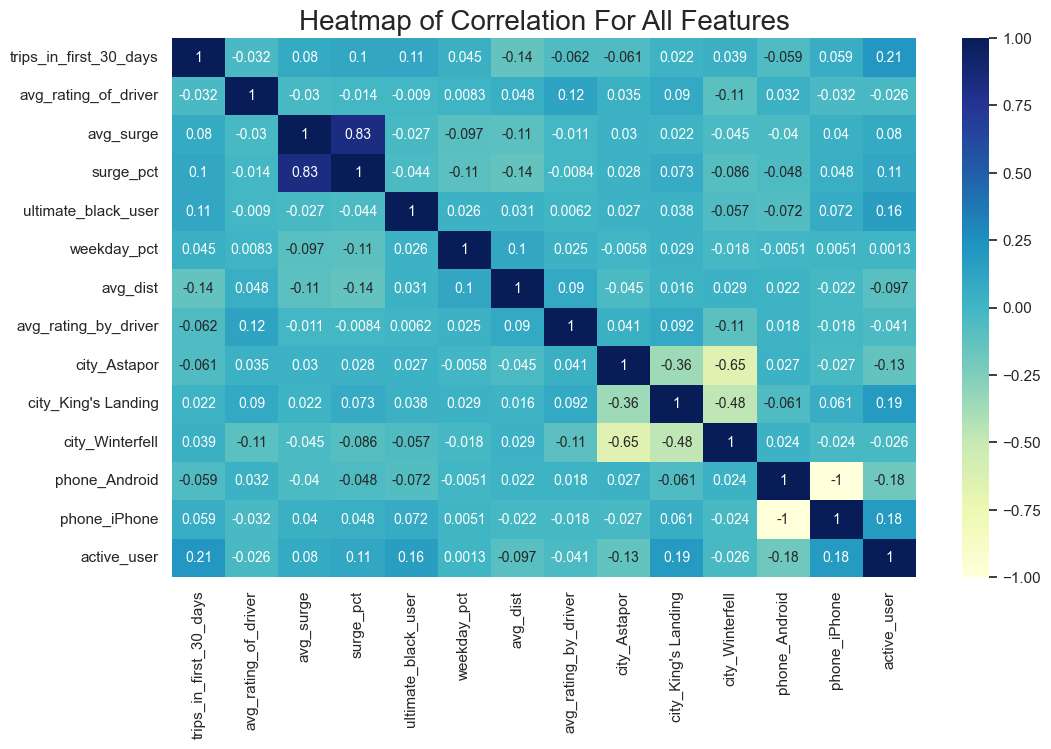

In [462]:
# plotting correlation heatmap
df=ultimate.copy()
df['active_user'] = df['active']
df=df.drop('active',axis=1)
_ = plt.figure(figsize=(12,7))
_ =sns.heatmap(df.corr(method='pearson'), cmap="YlGnBu", annot=True, annot_kws={'size':10}) 
_ = plt.title('Heatmap of Correlation For All Features', size=20)

Based on the significance of features in two models and the correlation between features and the target variable, I have identified five crucial features influencing user retention.\
**1.	Phone Type (iPhone):** According to the earlier exploratory data analysis (EDA), users with iPhones exhibit a higher likelihood of remaining active after six months. Consequently, launching additional advertising campaigns targeting iPhone users could prove beneficial.\
**2.	Ultimate Black User Status:** Users who opt for the Ultimate Black option within their initial 30 days tend to show higher retention rates. Introducing promotions for Ultimate Black during the first 30 days might contribute to an increase in the overall retention rate.\
**3.	City (King’s Landing):** Residents of King’s Landing are more inclined to stay active after six months. Focusing promotional efforts, such as increased advertising or specific promotional activities, in this city may enhance user retention.\
**4.	Trips in the First 30 Days:** This feature exhibits a strong positive correlation with our target variable. Offering promotions to users during their initial 30 days and encouraging them to utilize the Ultimate service extensively could potentially elevate the retention rate.\
**5.	Surge Percentage:** The surge percentage feature also demonstrates a positive correlation with our target. Users with a higher percentage of trips involving surge multipliers greater than 1 exhibit a higher likelihood of staying. Rather than imposing extra fees on all users, it is advisable to recognize the importance of these users and provide them with targeted promotions.\
By strategically addressing these identified features, it is possible to implement promotional campaigns and activities that specifically target user segments with a higher propensity for retention, ultimately contributing to the overall success of the service.
